In [ ]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)  # Only allocate needed memory
#     except RuntimeError as e:
#         print(e)

2025-03-18 21:21:25.926157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742313085.938804   13191 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742313085.943364   13191 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 21:21:25.958100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet50, InceptionV3


In [4]:
# Loading the Data
def load_data(data_dir):
    filepaths = []
    labels = []

    folders = os.listdir(data_dir)

    for fold in folders:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepath = os.path.join(foldpath, file)

            filepaths.append(filepath)
            labels.append(fold)

    F = pd.Series(filepaths, name = 'filepaths')
    L = pd.Series(labels, name='labels')

    df = pd.concat([F, L], axis=1)

    return df


In [5]:
data_dir = "/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/flowers"

df = load_data(data_dir)

df

,filepaths,labels
0,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,daisy
1,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,daisy
2,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,daisy
3,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,daisy
4,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,daisy
...,...,...
4312,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,tulip
4313,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,tulip
4314,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,tulip
4315,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,tulip


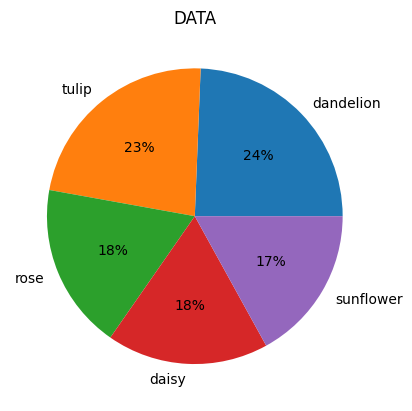

labels
dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: count, dtype: int64

In [6]:
data_balance = df.labels.value_counts()
plt.pie(data_balance, labels=data_balance.index, autopct='%.0f%%')
plt.title("DATA")
plt.show()

data_balance

In [7]:
# df_gen = ImageDataGenerator(rescale=1./255)

# generator = df_gen.flow_from_dataframe(df, x_col= 'filepaths', y_col= 'labels', target_size= (224, 224), class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= 16)


In [8]:
# df_extracted = pd.DataFrame({
#     'filepaths': generator.filenames,   # Extract file paths
#     'labels': list(generator.classes)   # Extract numeric labels
# })

In [9]:
# class_mapping = {v: k for k, v in generator.class_indices.items()}  # Reverse the dictionary

# # Convert numeric labels back to original labels
# df_extracted['labels'] = df_extracted['labels'].map(class_mapping)

# print(df_extracted)

In [10]:
# df = pd.concat([df, df_extracted], ignore_index=True)
# df

In [11]:
# Hybrid Sampling on the Dataset
mean_samples = int(df['labels'].value_counts().mean())

df = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(mean_samples, replace=len(x) < mean_samples, random_state=42)
).reset_index(drop=True)


/tmp/ipykernel_4443/2425877260.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(mean_samples, replace=len(x) < mean_samples, random_state=42)


In [12]:
df = df.copy().reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
df

,filepaths,labels
0,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,tulip
1,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,rose
2,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,rose
3,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,rose
4,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,sunflower
...,...,...
4310,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,sunflower
4311,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,daisy
4312,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,sunflower
4313,/mnt/windows/Users/ASUS/Desktop/ML DL GenAI/fl...,tulip


In [14]:
df.value_counts('labels')

labels
daisy        863
dandelion    863
rose         863
sunflower    863
tulip        863
Name: count, dtype: int64

In [15]:
train_df, tst_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

valid_df, test_df = train_test_split(tst_df, train_size=0.5, shuffle=True, random_state=42)

In [16]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [17]:
print(len(train_df), len(valid_df), len(test_df))


3452 431 432


In [18]:
batch_size = 8
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_gen = train_datagen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 8)

valid_gen = train_datagen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 8)

test_gen = train_datagen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= 8)



Found 3452 validated image filenames belonging to 5 classes.
Found 431 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


IndexError: index 8 is out of bounds for axis 0 with size 8

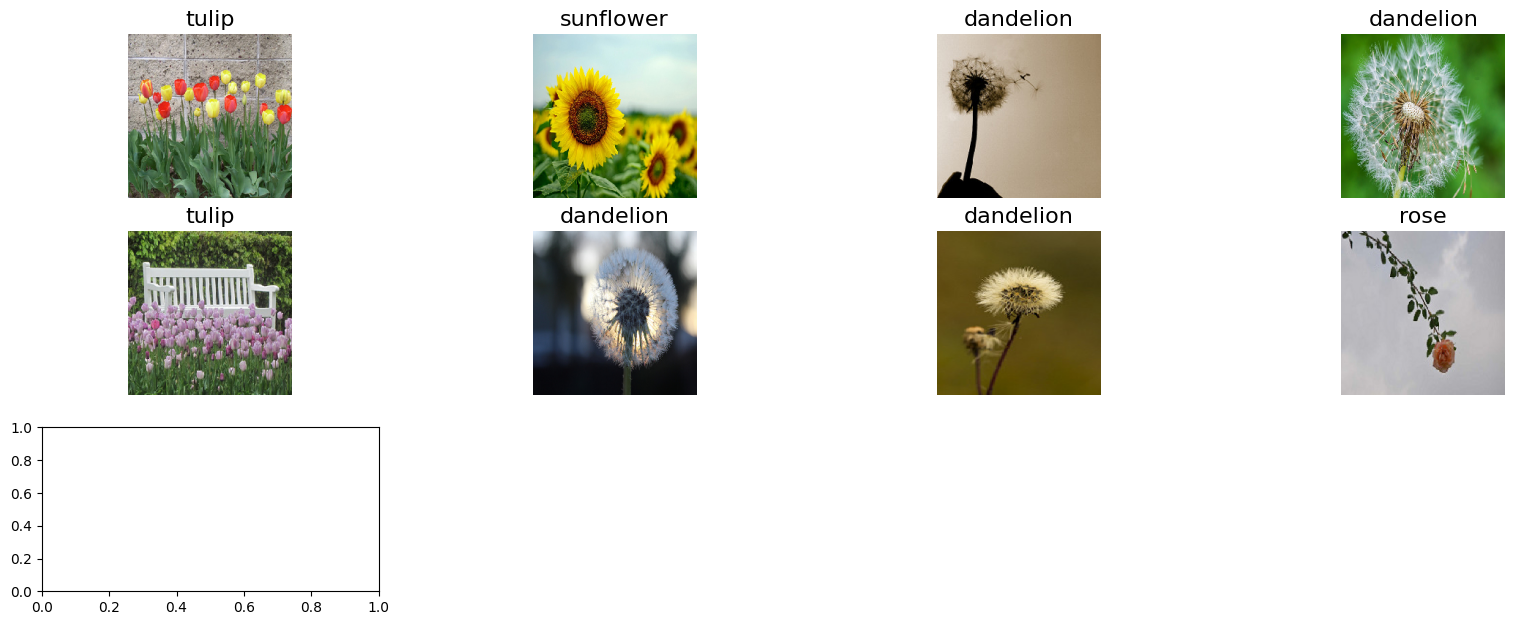

In [19]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys()) 
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(8, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='black', fontsize=16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred



def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= 'Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()



In [21]:
img_shape = (224, 224, 3) # shape, channel
class_counts = len(list(train_gen.class_indices.keys()))

In [22]:
model = Sequential()
model.add(Conv2D(filters =16, kernel_size=(3,3), padding= 'same', activation= 'relu', input_shape= img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(class_counts, activation = "softmax"))

/home/apoorv/miniforge3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742310584.092199    4443 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1688 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [23]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,793,541 (10.66 MB)

 Trainable params: 2,792,165 (10.65 MB)

 Non-trainable params: 1,376 (5.38 KB)

In [24]:
history = model.fit(train_gen, validation_data=valid_gen, epochs= 20, verbose= 1, shuffle= True)

Epoch 1/20


/home/apoorv/miniforge3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1742310588.224204    4953 service.cc:148] XLA service 0x7174280020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742310588.224389    4953 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-18 20:39:48.313861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742310588.791844    4953 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-18 20:39:49.054509: W externa

  5/432 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.1558 - loss: 2.5672 

I0000 00:00:1742310597.033560    4953 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


432/432 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.2960 - loss: 2.0537 - val_accuracy: 0.2065 - val_loss: 3.1759
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4199 - loss: 1.5991 - val_accuracy: 0.4988 - val_loss: 1.3142
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4970 - loss: 1.3964 - val_accuracy: 0.5128 - val_loss: 1.2269
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4984 - loss: 1.3561 - val_accuracy: 0.5731 - val_loss: 1.1299
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5321 - loss: 1.2703 - val_accuracy: 0.5638 - val_loss: 1.0701
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5747 - loss: 1.1318 - val_accuracy: 0.6172 - val_loss: 1.0214
Epoch 7/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5677 - loss: 1.1812 - val_accuracy: 0.6520 - val_loss: 0.9919
Epoch 8/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5855 - loss: 1.1047 - val_accurac

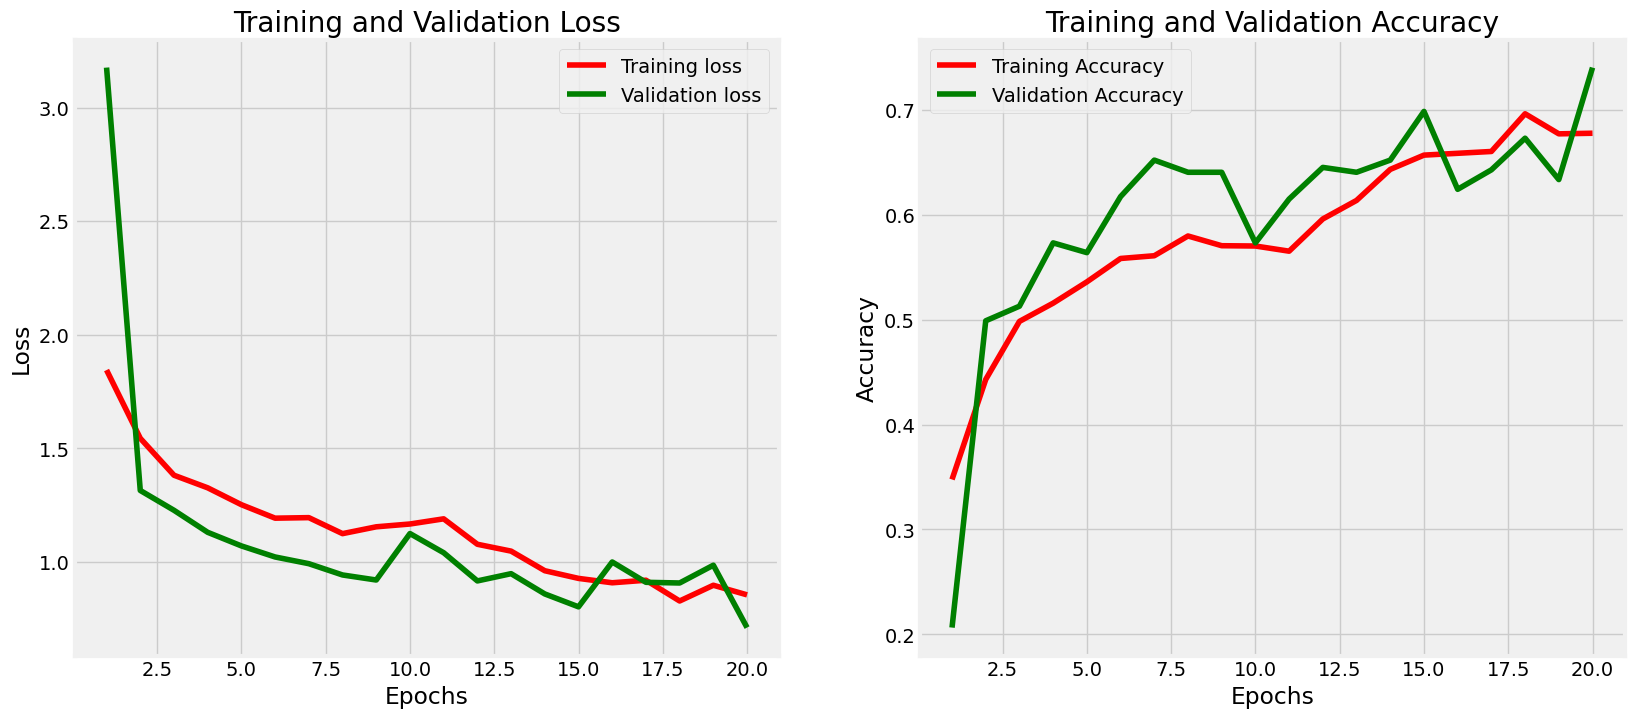

In [25]:
model_performance(history, 20)

In [26]:
model_evaluation(model)

432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8328 - loss: 0.5115
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7710 - loss: 0.6605
11/54 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8052 - loss: 0.6384

/home/apoorv/miniforge3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7488 - loss: 0.7220
Train Loss:  0.5084001421928406
Train Accuracy:  0.8398030400276184
--------------------
Validation Loss:  0.710564374923706
Validation Accuracy:  0.7401391863822937
--------------------
Test Loss:  0.8001828193664551
Test Accuracy:  0.7245370149612427


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


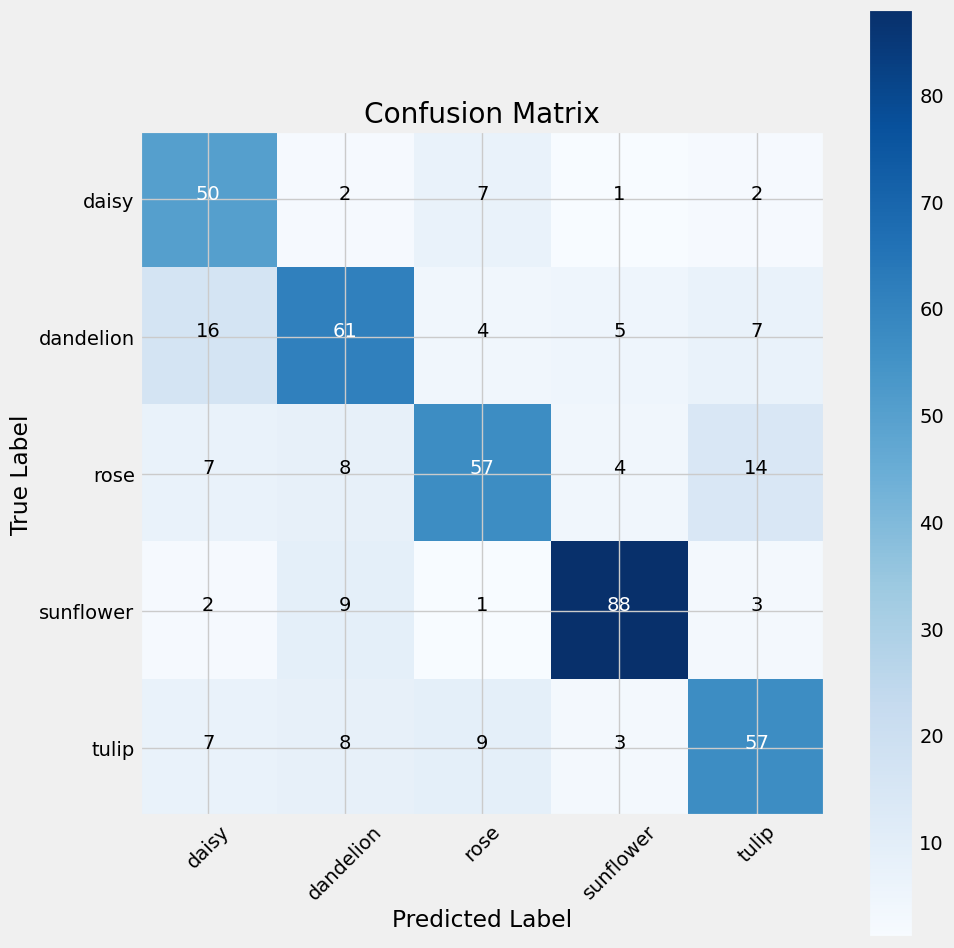

In [27]:
y_pred = get_pred(model, test_gen)

plot_confusion_matrix(test_gen, y_pred)

## Transfer Learning

EfficientNetB3

In [28]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling = None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

prediction = Dense(class_counts, activation='softmax')(x)  # Class Count calculated above

EfficientNetB3_model = Model(inputs=base_model.input, outputs=prediction)

In [29]:
EfficientNetB3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB3_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,223,592 (16.11 MB)

 Trainable params: 4,178,689 (15.94 MB)

 Non-trainable params: 44,903 (175.41 KB)

In [30]:
EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, validation_data=valid_gen, epochs=20, verbose=1, shuffle=True)

Epoch 1/20


2025-03-18 20:44:28.960544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 264 bytes spill stores, 264 bytes spill loads



432/432 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - accuracy: 0.3308 - loss: 1.8644 - val_accuracy: 0.4037 - val_loss: 1.3795
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6074 - loss: 1.0618 - val_accuracy: 0.3318 - val_loss: 1.5000
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7063 - loss: 0.8134 - val_accuracy: 0.4896 - val_loss: 1.1463
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7455 - loss: 0.7281 - val_accuracy: 0.6311 - val_loss: 0.9780
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7839 - loss: 0.6064 - val_accuracy: 0.7169 - val_loss: 0.7369
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8140 - loss: 0.5389 - val_accuracy: 0.7494 - val_loss: 0.6887
Epoch 7/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8404 - loss: 0.5016 - val_accuracy: 0.6961 - val_loss: 0.9032
Epoch 8/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8286 - loss: 0.4905 - val_accur

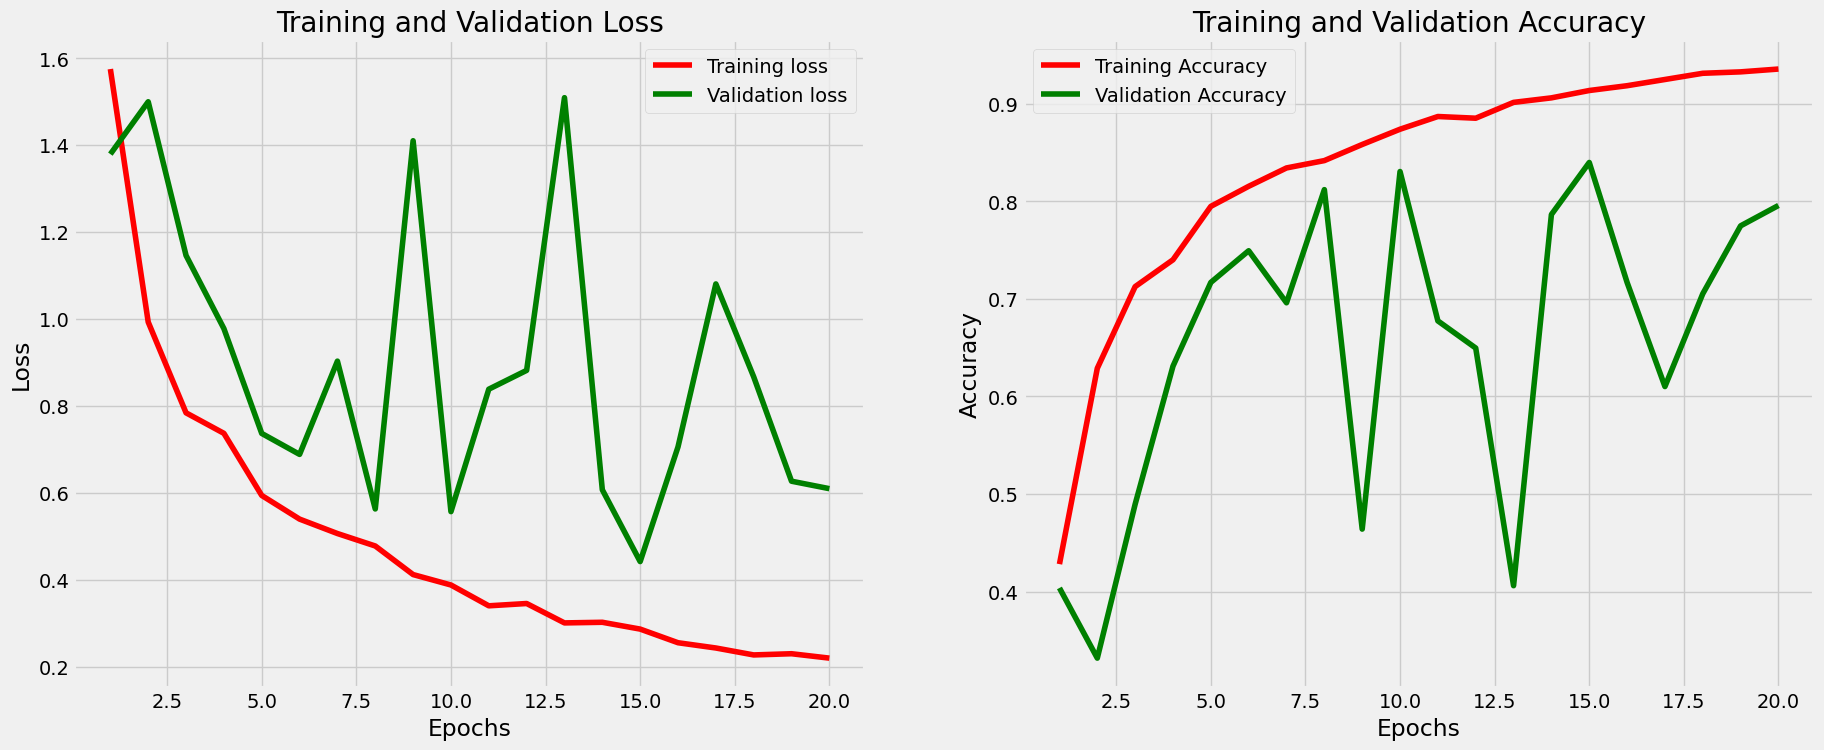

In [31]:
model_performance(EfficientNetB3_history, 20)

In [32]:
model_evaluation(EfficientNetB3_model)

432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8854 - loss: 0.3267
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7870 - loss: 0.7074
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8558 - loss: 0.5110
Train Loss:  0.33117279410362244
Train Accuracy:  0.8878910541534424
--------------------
Validation Loss:  0.6098079681396484
Validation Accuracy:  0.7958236932754517
--------------------
Test Loss:  0.5756918787956238
Test Accuracy:  0.8101851940155029


VGG16

In [34]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

# freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 58s 1us/step


In [35]:
VGG16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,145,861 (57.78 MB)

 Trainable params: 7,510,597 (28.65 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [36]:
VGG16_history = VGG16_model.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20


2025-03-18 20:59:04.501475: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5946 - loss: 0.3540

2025-03-18 20:59:53.105271: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5949 - loss: 0.3537

2025-03-18 21:00:04.019882: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


432/432 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.5953 - loss: 0.3534 - val_accuracy: 0.8469 - val_loss: 0.1531
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.9064 - loss: 0.1053 - val_accuracy: 0.8376 - val_loss: 0.1570
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9496 - loss: 0.0583 - val_accuracy: 0.9095 - val_loss: 0.1065
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9695 - loss: 0.0316 - val_accuracy: 0.8863 - val_loss: 0.1142
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9784 - loss: 0.0230 - val_accuracy: 0.9165 - val_loss: 0.1097
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9823 - loss: 0.0249 - val_accuracy: 0.8933 - val_loss: 0.1657
Epoch 7/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9900 - loss: 0.0141 - val_accuracy: 0.8863 - val_loss: 0.1841
Epoch 8/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9906 - loss: 0.0150 - val_accura

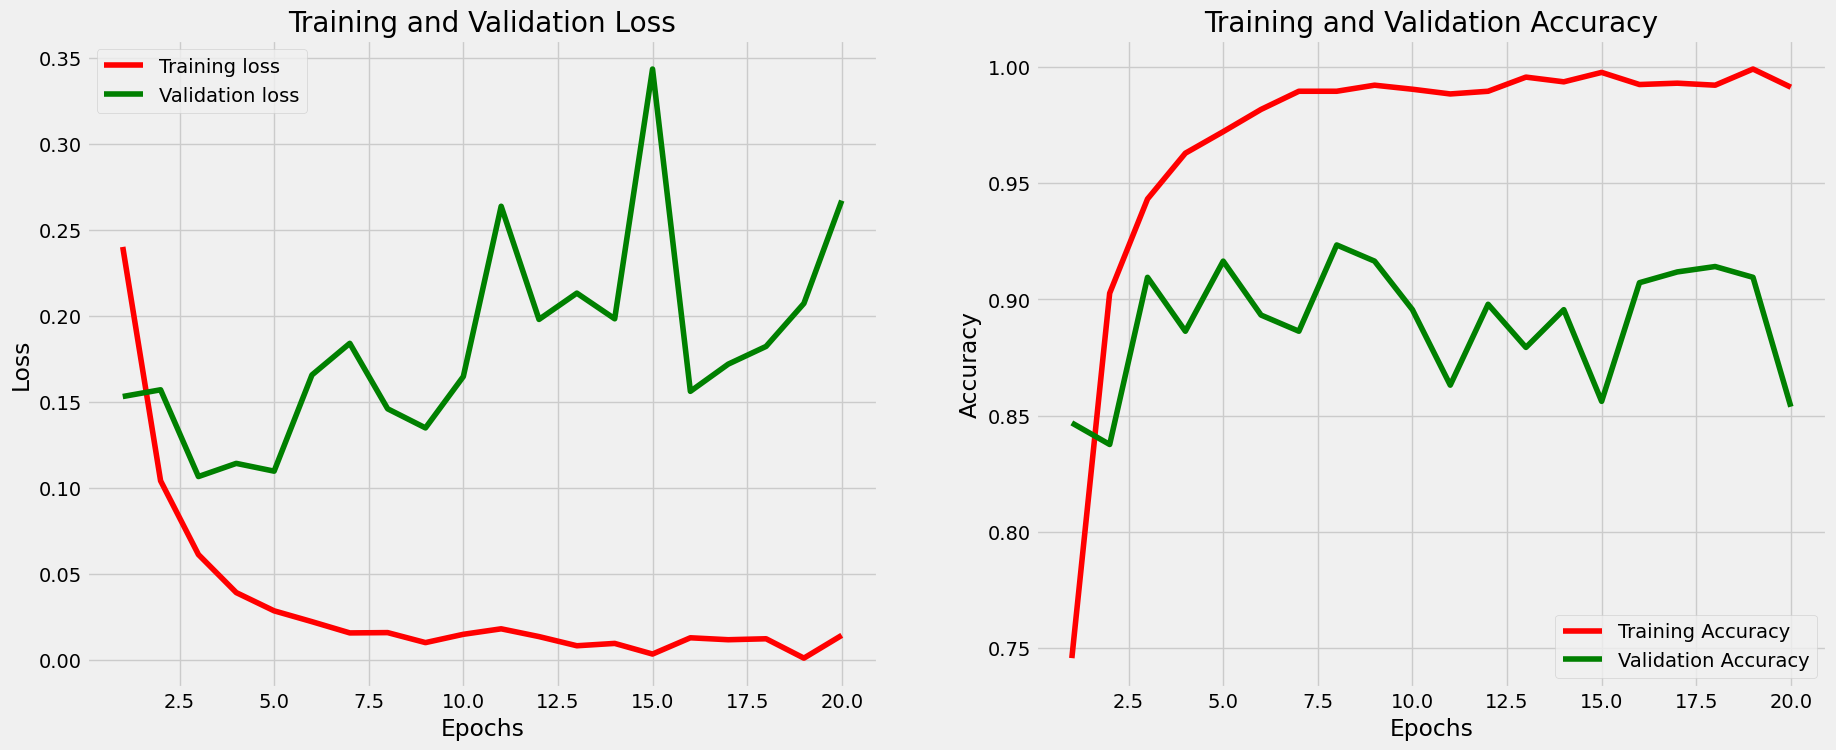

In [37]:
model_performance(VGG16_history, 20)

In [38]:
model_evaluation(VGG16_model)

432/432 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9620 - loss: 0.0584
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8537 - loss: 0.2855
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8499 - loss: 0.2397
Train Loss:  0.058877553790807724
Train Accuracy:  0.9577056765556335
--------------------
Validation Loss:  0.26715168356895447
Validation Accuracy:  0.8538283109664917
--------------------
Test Loss:  0.24522650241851807
Test Accuracy:  0.8611111044883728


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


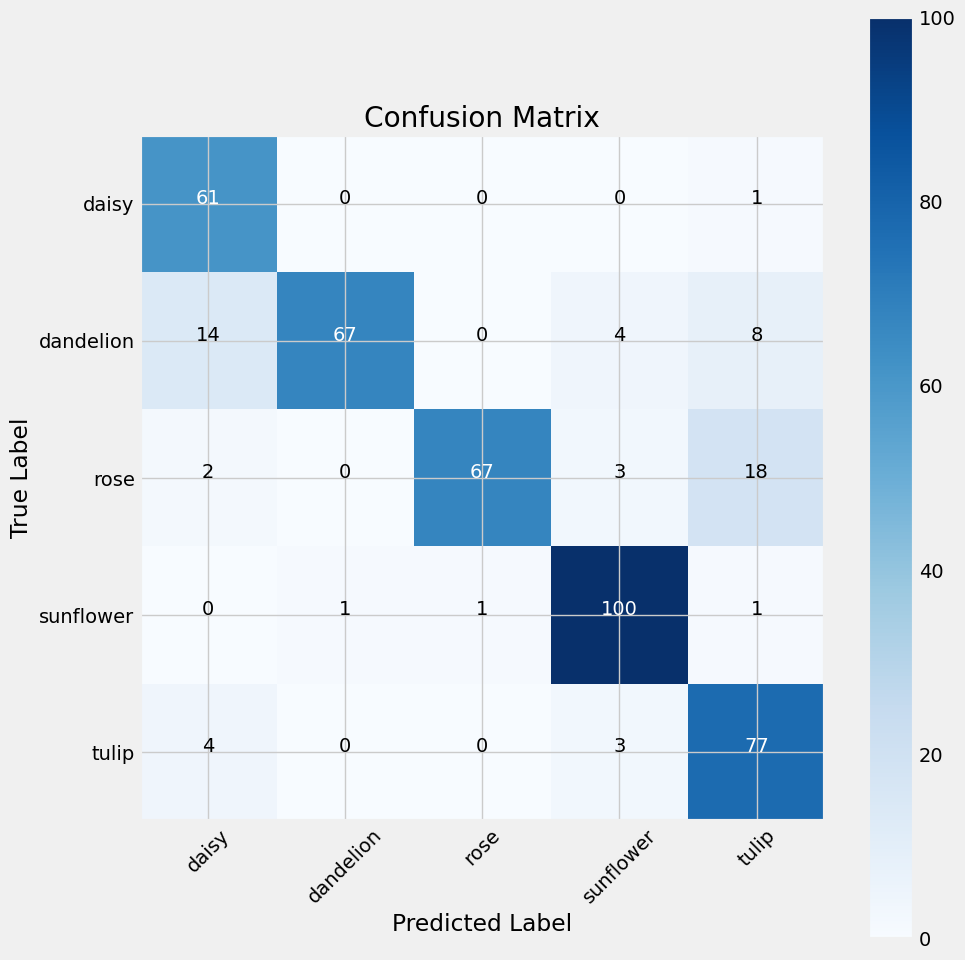

In [39]:
y_pred = get_pred(VGG16_model, test_gen)
plot_confusion_matrix(test_gen, y_pred)